# Question 1 **<font color="red">Good</font>**

**Fully convolutional networks for image denoising (40%)**



1.   Created a custom pyTorch Dataset that contains the Lfw pairs of pictures
     (noisy,clean) after adding the noise and doing other transformations - and split the data to train, validation and test sets

2.   Designed an AutoEncoder with 4 convolutional layers 3 pooling layer in the
     encoder and 4 transposed convolutional layers in the decoder  

3.   Trained the model for 50 epochs using MSE and achieved 0.001 loss

4.   Conducted quantitative and qualitative evaluation on the unseen test set
     with some visual examples from test set




## Imports

In [ ]:
import os
import numpy as np
import cv2

import pandas as pd
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import image
import torch
import torchvision
import torch.nn as nn
import torch.optim  as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset , DataLoader
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/ASIM')


Drive already mounted at /content/ASIM; to attempt to forcibly remount, call drive.mount("/content/ASIM", force_remount=True).


## Data Pre Processing + Building Pytorch Dataset



> Loaded Data from Google drive



> Applied Noise and other transformations



> Created a customized PyTorch Dataset (;






### Load Data

Data is on my Drive, I unzipped them on colab environmet to manipulate them easily

Streaming output truncated to the last 5000 lines.
  inflating: LFW/lfwcrop_color/faces/Andre_Agassi_0022.ppm  
  inflating: LFW/lfwcrop_color/faces/Kenneth_Bowersox_0001.ppm  
  inflating: LFW/lfwcrop_color/faces/Hans_Blix_0012.ppm  
  inflating: LFW/lfwcrop_color/faces/Boris_Trajkovski_0001.ppm  
  inflating: LFW/lfwcrop_color/faces/Colin_Powell_0063.ppm  
  inflating: LFW/lfwcrop_color/faces/Sergio_Garcia_0001.ppm  
  inflating: LFW/lfwcrop_color/faces/Otto_Reich_0001.ppm  
  inflating: LFW/lfwcrop_color/faces/Tony_Elias_0001.ppm  
  inflating: LFW/lfwcrop_color/faces/Hosni_Mubarak_0004.ppm  
  inflating: LFW/lfwcrop_color/faces/Misty_Dawn_Clymer_0001.ppm  
  inflating: LFW/lfwcrop_color/faces/Heidi_Klum_0002.ppm  
  inflating: LFW/lfwcrop_color/faces/Roh_Moo-hyun_0026.ppm  
  inflating: LFW/lfwcrop_color/faces/Larry_Tanenbaum_0001.ppm  
  inflating: LFW/lfwcrop_color/faces/Kate_Winslet_0004.ppm  
  inflating: LFW/lfwcrop_color/faces/George_W_Bush_0519.ppm  
  inflating: LFW/lfwcrop

array([[[188, 140, 101],
        [195, 143, 100],
        [202, 148, 101],
        ...,
        [ 55,  39,  24],
        [ 37,  26,  19],
        [ 36,  23,  21]],

       [[190, 144, 105],
        [197, 146, 104],
        [202, 148, 102],
        ...,
        [ 65,  47,  35],
        [ 42,  27,  23],
        [ 39,  22,  24]],

       [[194, 147, 109],
        [200, 150, 108],
        [203, 150, 104],
        ...,
        [ 76,  54,  41],
        [ 47,  29,  26],
        [ 41,  22,  24]],

       ...,

       [[180, 135, 100],
        [176, 132,  97],
        [173, 129,  94],
        ...,
        [194, 125,  89],
        [164,  84,  51],
        [137,  50,  16]],

       [[185, 140, 106],
        [184, 140, 105],
        [175, 132,  97],
        ...,
        [174, 101,  63],
        [147,  62,  28],
        [131,  37,   4]],

       [[189, 143, 109],
        [192, 147, 113],
        [181, 137, 103],
        ...,
        [156,  79,  41],
        [135,  44,  11],
        [131,  31,   0]]], dtype=uint8)
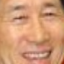

In [ ]:
# Here , unzip the pictures to google colab environment, then show an example of one of the pictures
! unzip /content/ASIM/MyDrive/lfwcrop_color.zip -d LFW
image.imread("/content/LFW/lfwcrop_color/faces/Lee_Jun_0001.ppm")

### Apply Noise and other transformations


1 - transform to tensors --> which normalizes the images to (0,1) range

2 - add a 10% gaussain noise to each image

3 - clip the values to be in the specified range of 0,1

Example Processed image


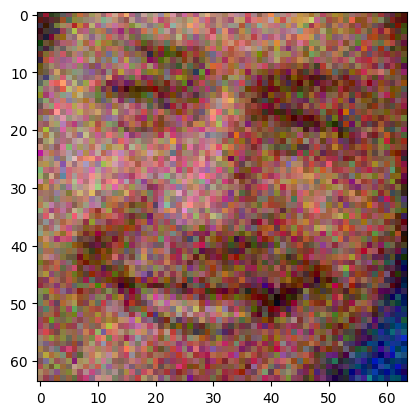

In [ ]:
#  This function basically takes the images and do the transforms on them,
#  turn them to tensors in range of 0-1 ,
#  then add the gaussian noise and return both the clean and noised image

def transform_images(img, std):

  to_tensor = transforms.ToTensor()
  img = to_tensor(img)

  noise = torch.randn(size = img.shape) * std
  noisy_img = img + noise
  noisy_img = torch.clip(noisy_img , 0 , 1 )

  return noisy_img ,img
clean_imgs_path = '/content/LFW/lfwcrop_color/faces'
# to save processed images
save_dir = '/content/processed_images/'

# make sure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

processed = []
img_list = os.listdir('/content/LFW/lfwcrop_color/faces')

for img in img_list:
  pic = image.imread(os.path.join(clean_imgs_path,img))

  # now apply the function on every image
  noisy_img ,clean_img = transform_images(pic, 0.1)
  processed.append((noisy_img, clean_img))


  # Actuallly no need to save the processed images on the disk, i can use the list above directly
  # np.save(os.path.join(save_dir, f'{img.split(".")[0]}.npy'), noisy_img.numpy())


print("Example Processed image")
plt.imshow(processed[0][0].permute(1,2,0))

### Create Dataset

> 1- In this step I created a pytorch dataset, which is a class that take list of noisy and clean images we processed above in "processesd" list and return a ready to use dataset, with the output being either training set or validation set or test set with "split'. PyTorch Datasets  https://www.youtube.com/watch?v=PXOzkkB5eH0


> 2- Next step is to instantiate the Train, validation and test sets and make data loaders that put the data into batches of 32 ready for the model training


> 3- The last step is to give some samples of the noisy data and their corresonding targets "clean images". this represents the final dataset that is going to be used to train the model






In [ ]:
class LFWDataset(Dataset):

  def __init__(self,split = 'train'):
    # super(LFWDataset,self).__init__()
    self.total = len(processed)
    if split == 'train':
      self.x = [img[0] for img in processed[:round(self.total*0.8)]]
      self.y = [img[1] for img in processed[:round(self.total*0.8)]]
      self.num_samples = len(self.x)
    elif  split == 'validation' :
      self.x = [img[0] for img in processed[round(self.total*0.8):round(self.total*0.9)]]
      self.y = [img[1] for img in processed[round(self.total*0.8):round(self.total*0.9)]]
      self.num_samples = len(self.x)
    elif split == 'test':
      self.x = [img[0] for img in processed[round(self.total*0.9):]]
      self.y = [img[1] for img in processed[round(self.total*0.9):]]
      self.num_samples = len(self.x)

  def __getitem__(self,index):
    return self.x[index],self.y[index]

  def __len__(self):
    return self.num_samples


In [ ]:
# Train, Validation and Test splits
LFW_train = LFWDataset()
LFW_valid = LFWDataset(split = 'validation')
LFW_test = LFWDataset(split = 'test' )

# create dataLoaders
train_loader = DataLoader(LFW_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(LFW_valid, batch_size=32, shuffle=True)
test_loader = DataLoader(LFW_test, batch_size=32, shuffle=False)
# show the split sizes
len(LFW_train),len(LFW_test),len(LFW_valid)

(10586, 1323, 1324)

In [ ]:
# show the shape of the data -> 32 batch size, then noissy image of 3,64,64 and clean image of 3,64,64
for inputs, targets in valid_loader:
  print("noisy image: ",inputs.shape)
  print("clean image: " ,targets.shape)
  break


noisy image:  torch.Size([32, 3, 64, 64])
clean image:  torch.Size([32, 3, 64, 64])


loaded 5 images


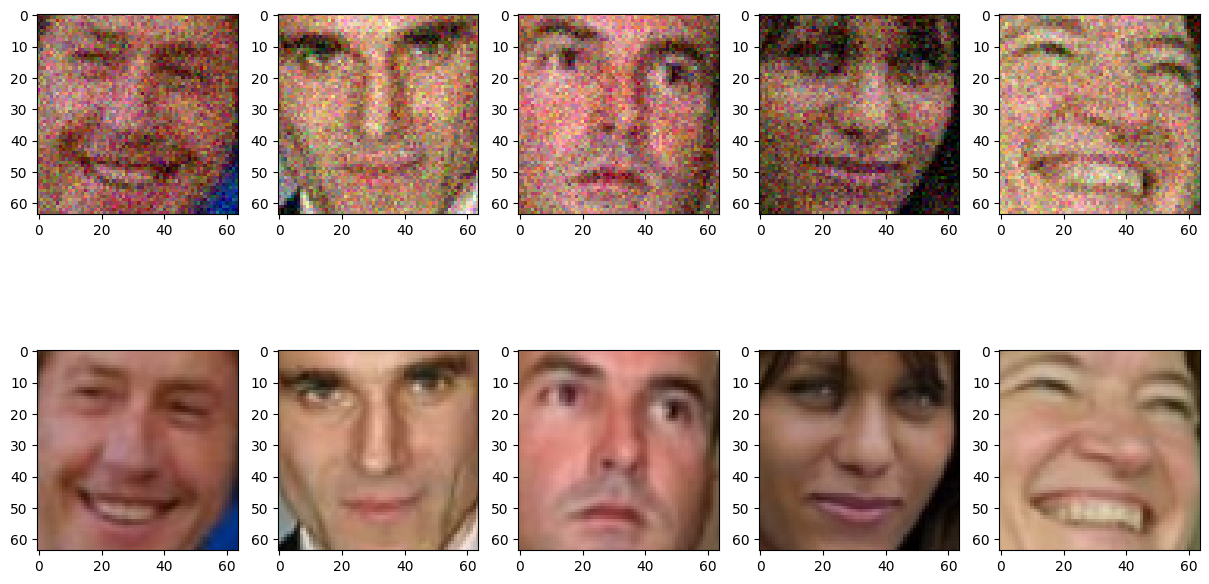

In [ ]:
# Illustrate some noisy and clean examples
processed_images = []
n = 0

#  show examples
for noisy_img, clean_img in LFW_train:
    processed_images.append((noisy_img, clean_img))
    n += 1
    if n % 5 == 0:
        print(f"loaded {n} images")
        break

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
# plot exampleee
for i in range(5):
    asim_clean, asim_noisy = processed_images[i]

    asim_clean = asim_clean.permute(1, 2, 0)
    asim_noisy = asim_noisy.permute(1, 2, 0)

    # Plot clean and noisy ones
    axes[0, i].imshow(asim_clean)
    axes[1, i].imshow(asim_noisy)
plt.show()


## Designing the AutoEncoder **<font color="red">Good</font>**



> My choice for the number of layers in the encoder and the decoder is totaly arbitrary and did not follow any model. In the **ENCODER** I have 4 convolutional layers and 3 maxpooling layers with Relu activation in all layers, all this take the input of (32,3,64,64) at the first layer to a shape of (32,32,8,8).

> In the **DECODER** I have 4 transposed convolution layers, and I manipulated the strides and the padding so that i can get the original dimentions of the pictures without using the unpool layes, in order to try and make the code cleaner. this takes the dimentions from (32,32,8,8) back to (32,3,64,64) "the constructed image".





In [ ]:

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder,self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=3 , out_channels=32 , kernel_size=3 , stride = 1, padding = 1),  # 32, 3, 64,64  # ->  32, 32, 64,64
        nn.ReLU(),
        nn.AvgPool2d(kernel_size = 2 , stride = 2),                                          # ->  32, (32, 32,32 )

        nn.Conv2d(in_channels = 32 , out_channels=64 , kernel_size=3 , stride = 1 , padding = 1 ),  # ->  32, (64, 32,32)
        nn.ReLU(),
        nn.AvgPool2d(kernel_size = 2 , stride = 2),                                                            # ->  32, (64, 16,16 )

        nn.Conv2d(in_channels = 64 , out_channels=32 , kernel_size=3 , stride = 1 , padding = 1 ),            # ->  32, (32, 16,16)
        nn.ReLU(),
        nn.AvgPool2d(kernel_size = 2 , stride = 2),                                                            # ->  32, (32, 8 , 8)

        nn.Conv2d(in_channels = 32 , out_channels=32 , kernel_size=3 , stride = 1 , padding = 1 )              # ->  32, (32, 8,8)

    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=32 , out_channels=32 , kernel_size=3 , stride =2,padding = 1,output_padding=1),      #  32, (32, 8 , 8) -> # ->  32, (32, 16 , 16)
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels = 32 , out_channels=64 , kernel_size=3 , stride = 2, padding = 1,output_padding=1  ),               #   32, (32, 16 , 16) # ->  32, (64, 32 , 32)
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels = 64 , out_channels=32 , kernel_size=3 , stride = 2 ,padding = 1,output_padding=1),                 # 32, (64, 32 , 32)  ->  32, (32, 64 , 64)
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels = 32 , out_channels=3 , kernel_size=3 , stride =1 ,padding = 1  ),                #32, (32, 64 , 64) -> 32, (3, 64 , 64)
        nn.Sigmoid() # to give us normalizerd range between0-1 for the photo
    )


  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [ ]:
model = AutoEncoder()

# move the model to the GPU , if there any ;)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# observe the model layers, input dimentions, and no. of trainable parameters
summary(model, input_size=(3, 64, 64))

# see what device we are operating on
print(f" The device working right now is: {device}")



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
         AvgPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         AvgPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]          18,464
              ReLU-8           [-1, 32, 16, 16]               0
         AvgPool2d-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 32, 8, 8]           9,248
  ConvTranspose2d-11           [-1, 32, 16, 16]           9,248
             ReLU-12           [-1, 32, 16, 16]               0
  ConvTranspose2d-13           [-1, 64, 32, 32]          18,496
             ReLU-14           [-1, 64,

## Training The AutoEncoder **<font color="red">Good</font>**



> My Choice for **Loss Function**: I chose to use the Mean square error loss, because it it the most suited for such a task "denoising" where my model has to just reduce the difference in pixel values between the noisy image and the clean one. overall, it is a very suitable metric rather than using something like cross entropy which doesn't make sence. In short, this problem is more of a regression problem on every pixel, so the mean square error is the most suited one.

> To make my code modular, I designed two functions, the first does one epoch of training and the second one evvaluated the model on the validation set, both of them calculates the loss at each Batch in addition to the overall average loss, My best guess for the fluctuation in the loss is the effect of pooling layers.**<font color="red">?</font>**

> I trained the model for 50 Epochs, with a learnnig rate of 0.001 using Adam optimezer, my loss decreases from 0.003 to 0.001 in both the training and validation sets  

> I then plotted two figure showing the progress of the loss on the training and validation sets , the figures show  noisy pattern bu overall it is decreasing till convergence










### Implementnig the train, evaluate functions

In [ ]:
# Training Function for a single Epoch
criterion  = nn.MSELoss()
optimizer  = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

output = []
def train_model(model,epoch):
  model.train()  # Set model to training mode
  total_loss = 0
  # loop over all batches
  for idx , (inputs,targets) in enumerate(train_loader):

        # Put the data on gpu - if there is one
        inputs , targets = inputs.to(device), targets.to(device)

        # set gradients to zero
        optimizer.zero_grad()

        # calculate the forward pass -> predictions
        outputs = model(inputs)

        # now loss calculations
        loss = criterion(outputs, targets)

        # now backprob
        loss.backward()

        # now parameter update
        optimizer.step()


        total_loss += loss.item()

        # Print statistics every few batches
        # if idx % 20 == 0:
        #     print(f'Epoch [{epoch}], Batch [{idx}/{len(train_loader)}], '
        #           f'Batch Loss: {loss.item():.4f}, '
        #           f'Avg Loss so far: {total_loss / (idx + 1):.4f}')

    # Compute the average loss for the epoch
  avg_loss = total_loss / len(train_loader)
  print(f'Epoch {epoch} Training Loss: {avg_loss:.4f}')

  return avg_loss


# Evaluation Function
def model_validation(model,epoch):
    model.eval()  # Set model to evaluation mode
    validation_loss = 0.0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for idx, (inputs, targets)in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Accumulate statistics
            validation_loss += loss.item()

    # Compute average loss across the validation set
    avg_validation_loss = validation_loss / len(valid_loader)
    print(f'Epoch {epoch} validation Loss: {avg_validation_loss:.4f}')

    return avg_validation_loss

### Training loop

50 Epochs

In [ ]:
# Training loop
train_losses = []
validation_losses = []
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train_model(model,epoch)
    train_losses.append(train_loss)

    test_loss = model_validation(model,epoch)
    validation_losses.append(test_loss)

# Save the model
torch.save(model.state_dict(), 'AutoEncoder.pth')

Epoch 0 Training Loss: 0.0122
Epoch 0 validation Loss: 0.0053
Epoch 1 Training Loss: 0.0043
Epoch 1 validation Loss: 0.0038
Epoch 2 Training Loss: 0.0036
Epoch 2 validation Loss: 0.0034
Epoch 3 Training Loss: 0.0033
Epoch 3 validation Loss: 0.0031
Epoch 4 Training Loss: 0.0031
Epoch 4 validation Loss: 0.0030
Epoch 5 Training Loss: 0.0030
Epoch 5 validation Loss: 0.0028
Epoch 6 Training Loss: 0.0029
Epoch 6 validation Loss: 0.0027
Epoch 7 Training Loss: 0.0028
Epoch 7 validation Loss: 0.0026
Epoch 8 Training Loss: 0.0027
Epoch 8 validation Loss: 0.0026
Epoch 9 Training Loss: 0.0026
Epoch 9 validation Loss: 0.0026
Epoch 10 Training Loss: 0.0025
Epoch 10 validation Loss: 0.0024
Epoch 11 Training Loss: 0.0025
Epoch 11 validation Loss: 0.0023
Epoch 12 Training Loss: 0.0024
Epoch 12 validation Loss: 0.0023
Epoch 13 Training Loss: 0.0024
Epoch 13 validation Loss: 0.0023
Epoch 14 Training Loss: 0.0023
Epoch 14 validation Loss: 0.0025
Epoch 15 Training Loss: 0.0022
Epoch 15 validation Loss: 0.0

### Plots of loss over time on the Training and Validation sets

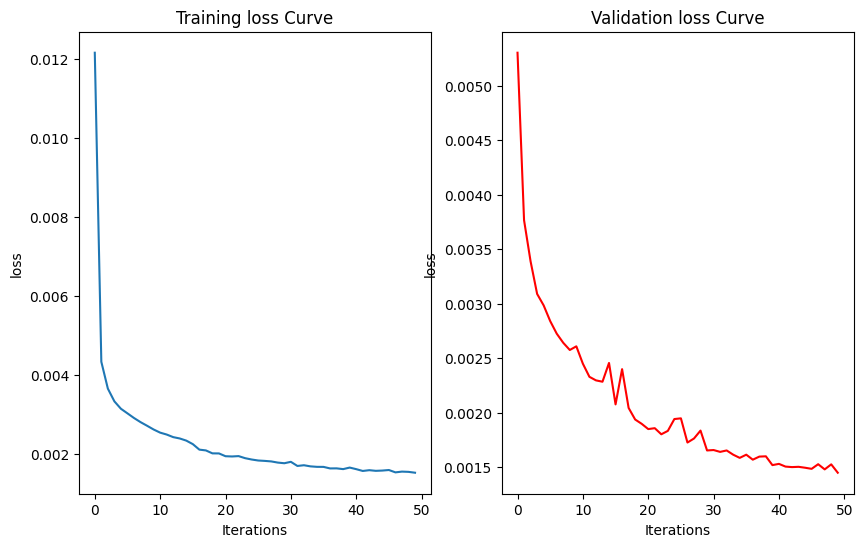

In [ ]:
# plotting the loss and the RMSE curves
def plot_loss(x_axis, y_axis ):
  plt.figure(figsize=(10, 6))
  plt.subplot(1,2,1)
  plt.plot(range(x_axis) , y_axis[0])
  plt.title('Training loss Curve')
  plt.xlabel('Iterations')
  plt.ylabel('loss')
  plt.subplot(1,2,2)
  plt.plot(range(x_axis) , y_axis[1] , c ='r')
  plt.title('Validation loss Curve')
  plt.xlabel('Iterations')
  plt.ylabel('loss')
  plt.show()

plot_loss(num_epochs , (train_losses,validation_losses ))

## Evaluation




> For testing the model, I have done a quantitative evaluation by passing a batch of the unseen test set to the model and then calculated the mse, it resulted in a great 0.0015 which indicates that the model indeed generalizes well.


> Then at the last part I did a qualitative evaluation by using the model to de-noise some images from the test-set,




### Quantitative Evaluation

In [ ]:
# Evaluation Function
def model_test(model):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for idx, (inputs, targets)in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            loss = criterion(model(inputs), targets)
            test_loss += loss.item()
    return test_loss / len(test_loader)

from torch.nn.functional import mse_loss
noised_images, clean_images = next(iter(test_loader))
clean_images = clean_images.to(device)
denoised_images = model(noised_images.to(device))
# Calculate MSE on test set
mse = mse_loss(denoised_images, clean_images).item()
MSE = model_test(model)
print(f"Mean Squared Error on one batch of Test Set: {mse:.4f}")
print(f"Mean Squared Error on the whole Test Set: {MSE:.4f}")



Mean Squared Error on one batch of Test Set: 0.0014
Mean Squared Error on the whole Test Set: 0.0015


### Qualitative Evaluation

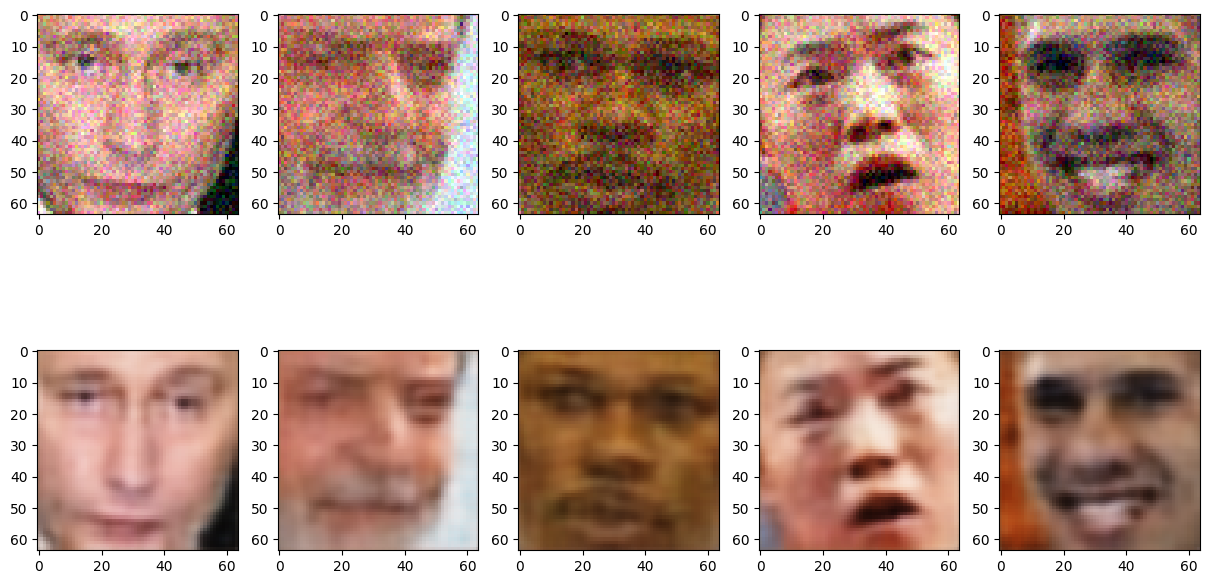

In [ ]:
test_batch = next(iter(test_loader))
noisy_images, clean_images = test_batch

noisy_images = noisy_images.to(device) # because the model is on the gpu

# pass it to the model to get denoised result
denoised_images = model(noisy_images).detach()

#  now to be able to plot, we neet the results in the cpu specifically
noisy_images = noisy_images.cpu()
denoised_images = denoised_images.cpu()

# now lets plot a bunch of denoised images
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i in range(5):
  #
  noisy_image     = noisy_images[i*2].permute(1, 2, 0)
  denoised_image  = denoised_images[i*2].permute(1, 2, 0)


  # Plot clean and noisy ones
  axes[0, i].imshow(noisy_image)
  axes[1, i].imshow(denoised_image)
plt.show()



### Discussion on Model Performance



>  the performance of the model is good in my openion, given the bad quality of the original images. The model learns how to remove the noise completly, but looks like there is a problem when trying to recover the original values of the pixels,


> This blurry reconstructions is the result of the model average pixel values value rather than the getting correct one, it smoothes the images to reduce noise, but at the cost of fine details, again, given that the original image was not of good quality, the model did great. **<font color="red">Good</font>**



